In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import fasttext
import regex as re  
import ast 

In [2]:
artists = 'dataset/artists.csv'
tracks = 'dataset/tracks.csv'

index_col = 0
df_artists = pd.read_csv(artists, sep=';', index_col=index_col)
df_tracks = pd.read_csv(tracks, index_col=index_col)

pd.set_option('display.max_columns', None)

## 💾 Optimizing Data Types for Efficiency

Before we proceed with cleaning and analysis, it's essential to ensure our DataFrames use the most **memory-efficient and appropriate data types**. Converting low-cardinality string columns (like `gender` and `nationality`) to the **`category`** dtype significantly reduces memory usage.

We'll also ensure all date columns are correctly parsed as **`datetime`** objects, and descriptive text fields are designated as the modern **`string`** dtype. For integer columns that contain `NaN` values, we use the nullable integer type **`Int64`**.

This step makes subsequent operations faster and more memory-friendly.

In [3]:
df_artists['gender'] = df_artists['gender'].astype('category')
df_artists['nationality'] = df_artists['nationality'].astype('category')
df_artists['country'] = df_artists['country'].astype('category')
df_artists['region'] = df_artists['region'].astype('category')
df_artists['province'] = df_artists['province'].astype('category')
df_artists['birth_place'] = df_artists['birth_place'].astype('category')
df_artists['birth_date'] = pd.to_datetime(df_artists['birth_date'], errors='coerce')
df_artists['active_start'] = pd.to_datetime(df_artists['active_start'], errors='coerce')
df_artists['description'] = df_artists['description'].astype('string')
df_artists['name'] = df_artists['name'].astype('string')

In [4]:
df_tracks['id_artist'] = df_tracks['id_artist'].astype('category')
df_tracks['id_album'] = df_tracks['id_album'].astype('category')
df_tracks['language'] = df_tracks['language'].astype('category')
df_tracks['album_type'] = df_tracks['album_type'].astype('category')
df_tracks['stats_pageviews'] = df_tracks['stats_pageviews'].astype('Int64')
df_tracks['year'] = pd.to_numeric(df_tracks['year'], errors = 'coerce').astype('Int64')
df_tracks['month'] = pd.to_numeric(df_tracks['month'], errors = 'coerce').astype('Int64')
df_tracks['day'] = pd.to_numeric(df_tracks['day'], errors = 'coerce').astype('Int64')
df_tracks['popularity'] = pd.to_numeric(df_tracks['popularity'], errors = 'coerce').astype('Int64')
df_tracks['n_sentences'] = df_tracks['n_sentences'].astype('Int64')
df_tracks['n_tokens'] = df_tracks['n_tokens'].astype('Int64')
df_tracks['disc_number'] = df_tracks['disc_number'].astype('Int64')
df_tracks['track_number'] = df_tracks['track_number'].astype('Int64')
df_tracks['explicit'] = df_tracks['explicit'].astype('bool')
df_tracks['modified_popularity'] = df_tracks['modified_popularity'].astype('bool')
df_tracks['album_release_date'] = pd.to_datetime(df_tracks['album_release_date'], errors='coerce')
df_tracks['name_artist'] = df_tracks['name_artist'].astype('string')
df_tracks['full_title'] = df_tracks['full_title'].astype('string')
df_tracks['title'] = df_tracks['title'].astype('string')
df_tracks['featured_artists'] = df_tracks['featured_artists'].astype('string')
df_tracks['primary_artist'] = df_tracks['primary_artist'].astype('string')
df_tracks['album_name'] = df_tracks['album_name'].astype('string')
df_tracks['album'] = df_tracks['album'].astype('string')
df_tracks['album_image'] = df_tracks['album_image'].astype('string')
df_tracks['lyrics'] = df_tracks['lyrics'].astype('string')

In [5]:
# Assuming your DataFrame is df_tracks and it's already loaded

def safe_literal_eval(value):
    """
    Safely converts a string representation of a list into a Python list.
    Handles NaN/missing values by returning an empty list or pd.NA.
    """
    if pd.isna(value) or value in (None, 'NaN', ''):
        # Return an empty list for missing values if you plan to iterate over it
        return []
    try:
        # Use ast.literal_eval for safe conversion of string-to-list
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        # Handle cases where the string is malformed or not a list structure
        print(f"Warning: Could not convert value: {value}")
        return [] # Default to empty list on failure

# Apply the conversion to both columns
df_tracks['swear_IT_words'] = df_tracks['swear_IT_words'].apply(safe_literal_eval)
df_tracks['swear_EN_words'] = df_tracks['swear_EN_words'].apply(safe_literal_eval)

## 🕵️ Data Validation: Checking and Correcting Primary Key Duplicates

For the data preparation phase, we start by performing a crucial check of the primary IDs for rows in both our DataFrames to check for potential duplicates. Ensuring unique identifiers is **foundational** for reliable joins and accurate analysis later on. 

A formal review of the primary ID columns yielded the following observations:

* **`df_tracks`**: Inspection of the track ID column revealed **73 instances of duplicated identifiers**. To guarantee that each record is uniquely identifiable and to maintain the principle of one-to-one entity mapping, these duplicated rows will be managed immediately. IDs are of the format $\text{TR\#\#\#\#\#\#}$, so we generate new IDs compliant with this format to replace duplicated ones.
* **`df_artists`**: The artist ID column was found to be **entirely sound**, presenting no instances of duplicate IDs. Consequently, no corrective action is required for this DataFrame regarding its primary keys.

The code below first validates the counts, displays a sample of the duplicates, and then executes the custom logic to **generate unique, non-colliding IDs** to replace the duplicated indices in `df_tracks`.

In [6]:
# 1. Creare un set di tutti gli ID esistenti per un controllo rapido
existing_tracks_ids = set(df_tracks.index)
existing_artists_ids = set(df_artists.index)

# 2. Identificare le posizioni (indice booleano) degli indici duplicati.
#    Usiamo keep='first' per segnare solo la seconda, terza, ecc. occorrenza.
duplicate_mask_tracks = df_tracks.index.duplicated()
duplicate_mask_artists = df_artists.index.duplicated()
num_duplicates_tracks = duplicate_mask_tracks.sum()
num_duplicates_artists = duplicate_mask_artists.sum()
print("number of duplicate index for tracks:", num_duplicates_tracks)
print("number of duplicate index for artists:", num_duplicates_artists)

number of duplicate index for tracks: 73
number of duplicate index for artists: 0


In [7]:
all_duplicates_mask = df_tracks.index.duplicated(keep=False)

df_duplicate_groups = df_tracks[all_duplicates_mask]
df_duplicate_groups_sorted = df_duplicate_groups.sort_index()


if not df_duplicate_groups_sorted.empty:
    print("Mostro tutte le righe che hanno un indice duplicato, ordinate per ID:")
    # Stampiamo le prime 30 (o modifica il numero se vuoi vederne di più)
    print(df_duplicate_groups_sorted.head(10))
else:
    # Questo scenario si verifica se num_duplicates (dal tuo codice) era 0
    print("Nessuna riga con indice duplicato trovata.")

Mostro tutte le righe che hanno un indice duplicato, ordinate per ID:
            id_artist      name_artist  \
id                                       
TR108862  ART56320683    Bassi Maestro   
TR108862  ART07127070      Noyz Narcos   
TR135764  ART73965015           Ghemon   
TR135764  ART86549066       Emis Killa   
TR190585  ART78209349             Coez   
TR190585  ART66932389           Piotta   
TR192351  ART81071062        Club Dogo   
TR192351  ART88792008    Jake La Furia   
TR205970  ART80977821  Jack The Smoker   
TR205970  ART08456301          Rancore   

                                                 full_title  \
id                                                            
TR108862                         Sushi Bar by Bassi Maestro   
TR108862                    SPINE by Noyz Narcos (Ft. Coez)   
TR135764                   Nessuno vale quanto te by Ghemon   
TR135764          Giovani eroi by Emis Killa (Ft. Not Good)   
TR190585     Nei treni la notte by Coez (Ft. Fr

We observed that rows with duplicate IDs contain different attribute values, meaning they are distinct records rather than exact duplicates. Dropping these rows would result in data loss.

Solution: We will retain these records by assigning them new, randomly generated indices. These new IDs will check against the existing set to ensure uniqueness while maintaining the original ID format (TRxxxxxx) for consistency.

In [8]:
# --- 1. Identify Duplicated Rows and Count ---
# Find the boolean mask for rows where the ID (index) is duplicated,
# keeping only the duplicates *after* the first occurrence.
duplicated_mask = df_tracks.index.duplicated(keep='first')
num_duplicates_to_replace = duplicated_mask.sum() # Should be 73
print(num_duplicates_to_replace)

# --- 2. Define ID Generation Helper ---
def format_track_id(number, prefix='TR', padding=6):
    """Formats a number into a TRXXXXXX string."""
    # Uses f-string formatting to zero-pad the number to 6 digits
    return f"{prefix}{number:0{padding}d}"

# --- 3. Generate New Unique IDs with Collision Check ---

# Convert the existing index to a set for O(1) average time complexity lookups
existing_ids = set(df_tracks.index)
new_track_ids = []

# Range for 6-digit numbers (000000 to 999999)
MIN_ID = 0
MAX_ID = 999999 

print(f"Generating {num_duplicates_to_replace} random unique IDs...")

while len(new_track_ids) < num_duplicates_to_replace:
    # Generate a random 6-digit number
    random_num = random.randint(MIN_ID, MAX_ID)
    
    # Format it to the "TRXXXXXX" string
    new_id = format_track_id(random_num)
    
    # Check for collision against all existing IDs
    if new_id not in existing_ids:
        new_track_ids.append(new_id)
        # Immediately add the new ID to the existing_ids set to prevent
        # generating the same random ID twice during this loop
        existing_ids.add(new_id)

print("Finished generating unique IDs.")

# --- 4. Replace Duplicated IDs in the DataFrame Index ---

# Get the actual index values that need to be replaced (the index values of the duplicated rows)
indices_to_replace = df_tracks.index[duplicated_mask]

# Create a Series of the new IDs, matching the indices (positions) of the duplicated rows
new_ids_series = pd.Series(
    new_track_ids,
    index=indices_to_replace
)

# Replace the duplicated index values in-place
df_tracks.index.values[duplicated_mask] = new_ids_series.values

# --- Verification ---
print(f"\nGenerated {len(new_track_ids)} new unique IDs.")
print(f"Example new ID: {new_track_ids[0]}")
print(f"Check for duplicates after replacement: {df_tracks.index.duplicated().any()}")

73
Generating 73 random unique IDs...
Finished generating unique IDs.

Generated 73 new unique IDs.
Example new ID: TR466317
Check for duplicates after replacement: False


## 🧹 Removing Redundant Artist Columns

We discovered that **`name_artist`**, **`name`**, and **`primary_artist`** all highlight the same information, creating unnecessary redundancy in our dataset. To determine which columns to keep, we performed a thorough **normalization and comparison analysis**.

After joining the tracks and artists DataFrames, we implemented a **helper function** to normalize all artist-related string columns. This normalization process includes:
- Converting to lowercase
- Removing accents (e.g., 'è' → 'e')  
- Stripping special characters
- Trimming whitespace

We applied this normalization to **`name`**, **`primary_artist`**, **`name_artist`**, and **`featured_artists`** to ensure a fair comparison. Our analysis revealed that **`primary_artist`** and **`name_artist`** are *identical* after normalization, while **`name`** contains the same unique values but with a slightly altered version for some artists, hence still being redundant.

We also checked for **self-titled tracks** (where the track name matches the artist name) and examined edge cases like featured artists. Based on these findings, we confidently **dropped** the redundant **`name`** and **`primary_artist`** columns, retaining only **`name_artist`** as this column (equivalent to **`primary_artist`**) matches the same version of how the artist name is written in **`featured_artists`**.


In [9]:
df = df_tracks.join(df_artists, on='id_artist')

In [10]:
def normalize_series(series):

    # 1. Start with the original series, handle cleaning first
    s = series.str.lower()
    
    # 2. Rimuove accenti e caratteri non-ascii (these typically propagate NaN/NA correctly)
    s = s.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    
    # 3. Rimuove caratteri speciali (this step can convert NA/NaN to '')
    s = s.str.replace(r'[^\w\s]', '', regex=True)
    
    # 4. Rimuove spazi extra all'inizio/fine e sostituisce multipli con uno singolo
    s = s.str.strip().str.replace(r'\s+', ' ', regex=True)

    # 5. CRITICAL STEP: Convert back all missing markers
    #    We check for three possibilities created during cleaning:
    #    a) The original NA/NaN value that was converted to the string 'nan' by some internal step.
    #    b) The resulting empty string ''
    #    c) A string containing only a single space ' ' (if strip() failed for some reason)
    s = s.replace('nan', pd.NA)  
    s = s.replace('', pd.NA)     
    s = s.replace(' ', pd.NA)    
    
    # Final step: Ensure the final output dtype is clean
    return s.astype('string')

In [11]:
# Applichiamo la normalizzazione alle tre colonne
df['name'] = normalize_series(df['name'])
df['primary_artist'] = normalize_series(df['primary_artist'])
df['name_artist'] = normalize_series(df['name_artist'])
df['featured_artists'] = normalize_series(df['featured_artists'])

In [12]:
# Controlla se le due colonne sono SEMPRE identiche
are_artists_identical = (df['primary_artist'] == df['name_artist']).all()

if are_artists_identical:
    print("Analisi: 'primary_artist' e 'name_artist' sono sempre identici dopo la normalizzazione.")
else:
    print("Analisi: 'primary_artist' e 'name_artist' NON sono sempre identici.")
    
    diff_df = df[df['primary_artist'] != df['name_artist']]
    print(diff_df[['primary_artist', 'name_artist', 'primary_artist', 'name_artist']].head())

Analisi: 'primary_artist' e 'name_artist' sono sempre identici dopo la normalizzazione.


In [13]:
# Cerca tracce omonime (dove il nome della traccia è uguale al nome dell'artista)
self_titled_tracks = df[df['name'] != df['primary_artist']]
print(self_titled_tracks[['name', 'primary_artist']])

                  name primary_artist
id                                   
TR317207   gue pequeno            gue
TR446826   gue pequeno            gue
TR228275   gue pequeno            gue
TR697556   gue pequeno            gue
TR391415   gue pequeno            gue
...                ...            ...
TR794750  samuel heron   samuel costa
TR102539  samuel heron   samuel costa
TR178809   joey funboy       joey ita
TR589443   joey funboy       joey ita
TR735987   joey funboy       joey ita

[870 rows x 2 columns]


In [14]:
df.drop(columns=['name', 'primary_artist'], inplace=True)
df.drop(columns=['active_end'], inplace=True)


Active_end column is completely empty so we can drop it

## 🔍 Analyzing `full_title`

### `full_title` vs `title` Redundancy

The **`full_title`** and **`title`** attributes should theoretically correspond, as both identify the track's name. However, **`full_title`** contains additional information by appending the performer with **"by (artist_name)"** and featuring artists with **"Ft. (featured_artists)"**.

This explains why **`full_title`** has more unique values compared to **`title`**. However, by examining the actual title name contained in the first portion of **`full_title`**, we notice that the two columns do in fact correspond to the same underlying track name.

We performed a **regex-based extraction and normalization** to verify this relationship holds across *all* records. The process involved:

- **Extracting** the title portion from **`full_title`** by splitting at the last occurrence of `" by"`
- **Normalizing smart quotes and apostrophes** (e.g., `'` → `'`, `"` → `"`) to handle encoding differences
- **Standardizing whitespace** by stripping leading/trailing spaces and collapsing multiple spaces into one

After these comprehensive normalization steps, we confirmed that the extracted title from **`full_title`** is *identical* to **`title`** across all rows. This allows us to confidently **discard** one of the two columns, eliminating redundancy while preserving complete information.

This verification ensures data integrity and simplifies our schema for future analysis. ✅

In [15]:
def normalize_title(series):
    """
    Normalize a pandas Series containing titles by:
    - Replacing smart quotes/apostrophes with straight ones
    - Stripping leading/trailing whitespace
    - Collapsing multiple spaces into single spaces
    """
    # Normalize smart apostrophes
    s = series.str.replace('’', "'", regex=False)
    s = s.str.replace('‘', "'", regex=False)

    # Normalize smart double quotes
    s = s.str.replace('“', '"', regex=False)
    s = s.str.replace('”', '"', regex=False)
    
    # Normalize whitespace
    s = s.str.strip()
    s = s.str.replace(r'\s+', ' ', regex=True)
    
    return s.astype('string')

In [16]:
df_title = df_tracks[['full_title', 'title']].copy()

# Extract title portion from full_title
split_series = df_title['full_title'].str.rsplit(' by', n=1)
df_title['cleaned_attribute'] = split_series.str[0]

# Apply normalization to both columns
df_title['cleaned_attribute'] = normalize_title(df_title['cleaned_attribute'])
df_title['title'] = normalize_title(df_title['title'])

# Compare results
are_columns_equal_final = (df_title['cleaned_attribute'] == df_title['title']).all()
print(f"Are the columns equal after normalization? {are_columns_equal_final}")

# Check the remaining mismatched rows (should now be 0)
final_mismatched_rows = df_title[df_title['cleaned_attribute'] != df_title['title']]
print(f"Number of rows still unequal: {len(final_mismatched_rows)}")

Are the columns equal after normalization? True
Number of rows still unequal: 0


## 🎵 Validating Artist and Featured Artists from `full_title`

Having established that **`full_title`** contains redundant information about track titles, we now investigate whether the **artist** and **featured artists** information embedded in **`full_title`** matches the dedicated columns **`name_artist`** and **`featured_artists`**.

The **`full_title`** follows the pattern: `"Track Name by Artist (Ft. Featured Artists)"` or `"Track Name by Artist, Featured Artist 1, ... & Featured Artist N"`. We perform a **multi-step extraction and normalization** process to validate this relationship.

In [17]:
df_artist_and_feat = df_tracks[['full_title', 'name_artist', 'featured_artists']].copy()

df_artist_and_feat['name_artist'] = normalize_title(df_artist_and_feat['name_artist'])
df_artist_and_feat['featured_artists'] = normalize_title(df_artist_and_feat['featured_artists'])
df_artist_and_feat['full_title'] = normalize_title(df_artist_and_feat['full_title'])

# --- Step 1: Extract 'artist_and_feat' (Artist + Features) ---
split_series_1 = df_artist_and_feat['full_title'].str.rsplit(' by', n=1)
df_artist_and_feat['artist_and_feat'] = split_series_1.str[1]
df_artist_and_feat.drop(columns=['full_title'], inplace=True)

# --- Step 2: Separate 'cleaned_artist' from 'cleaned_feat' ---
split_series_2 = df_artist_and_feat['artist_and_feat'].str.rsplit('(Ft.', n=1)
df_artist_and_feat['cleaned_artist'] = split_series_2.str[0]
df_artist_and_feat['cleaned_feat'] = split_series_2.str[1].str.replace(r'\)$', '', regex=True)

# --- NEW: Convert & to , BEFORE extracting the artist ---
df_artist_and_feat['cleaned_artist'] = df_artist_and_feat['cleaned_artist'].str.replace('&', ',', regex=False)

# --- Extract primary artist by splitting at the FIRST comma ---
split_series_3 = df_artist_and_feat['cleaned_artist'].str.split(',', n=1)
df_artist_and_feat['cleaned_artist'] = split_series_3.str[0]

# The remaining artists after the first comma become features
remaining_artists = split_series_3.str[1]

# --- Move remaining artists to 'cleaned_feat' if '(Ft....)' was empty ---
mask_empty_feat = df_artist_and_feat['cleaned_feat'].isna() | (df_artist_and_feat['cleaned_feat'].str.strip() == '')

df_artist_and_feat['cleaned_feat'] = df_artist_and_feat['cleaned_feat'].mask(
    mask_empty_feat,
    remaining_artists.fillna('').str.strip()
)

# --- Strip whitespace from cleaned_artist ---
df_artist_and_feat['cleaned_artist'] = df_artist_and_feat['cleaned_artist'].str.strip()

# --- Final Comparison ---
are_names_equal_final = (df_artist_and_feat['cleaned_artist'] == df_artist_and_feat['name_artist']).all()
print(f"Are the artist names equal? {are_names_equal_final}")

# Identify and print the remaining mismatched rows
final_mismatched_rows = df_artist_and_feat[df_artist_and_feat['cleaned_artist'] != df_artist_and_feat['name_artist']]
print(f"Number of rows still unequal: {len(final_mismatched_rows)}")

# if len(final_mismatched_rows) > 0:
#     print("\nSample of remaining mismatched rows:")
#     rows_to_display = final_mismatched_rows.head(10)
#     print(rows_to_display[['name_artist', 'cleaned_artist']])
    
#     print("\nFirst Mismatched Row Details:")
#     first_id = rows_to_display.index[0]
#     print(f"name_artist: '{df_artist_and_feat['name_artist'].loc[first_id]}'")
#     print(f"cleaned_artist: '{df_artist_and_feat['cleaned_artist'].loc[first_id]}'")

# df_artist_and_feat.drop(columns=['artist_and_feat'], inplace=True)
# print(df_artist_and_feat[['name_artist', 'cleaned_artist']].head(10))

Are the artist names equal? True
Number of rows still unequal: 0


After applying comprehensive normalization to compare **`cleaned_feat`** (extracted from **`full_title`**) with the original **`featured_artists`** column, we identified **413 mismatched rows**.

### Key Findings

The mismatches reveal a systematic pattern: in many cases, the original **`featured_artists`** column is *empty* while **`cleaned_feat`** contains valid artist names extracted from **`full_title`**. This indicates that **`full_title`** actually contains *more complete* information about featured artists than the dedicated **`featured_artists`** column.

In [18]:
def sort_artists(series):
    """
    Normalize and sort a pandas Series containing artist names by:
    - Replacing '&' with ',' for consistent delimiter
    - Splitting by comma into individual artists
    - Stripping whitespace from each artist name
    - Sorting artists alphabetically
    - Rejoining into a single comma-separated string
    
    Parameters:
    -----------
    series : pd.Series
        A pandas Series containing artist names (can be comma or ampersand-separated)
    
    Returns:
    --------
    pd.Series
        A normalized Series with alphabetically sorted, comma-separated artist names
    """
    # Replace & with , for consistent delimiter
    s = series.str.replace('&', ',', regex=False)
    
    # Split by comma, strip whitespace, and filter out empty strings
    list_artists = s.str.split(',').apply(
        lambda x: [item.strip() for item in x if item.strip()] if isinstance(x, list) else []
    )
    
    # Sort alphabetically
    sorted_artists = list_artists.apply(lambda x: sorted(x))
    
    # Rejoin into comma-separated string
    normalized_series = sorted_artists.apply(lambda x: ', '.join(x))
    
    return normalized_series

In [19]:
df_artist_and_feat['featured_artists'] = sort_artists(df_artist_and_feat['featured_artists'])
df_artist_and_feat['cleaned_feat'] = sort_artists(df_artist_and_feat['cleaned_feat'])

# Identify and print the remaining mismatched rows using the normalized series
final_mismatched_rows = df_artist_and_feat[df_artist_and_feat['cleaned_feat'] != df_artist_and_feat['featured_artists']]
print(f"Number of rows still unequal: {len(final_mismatched_rows)}")

# Print the remaining mismatched rows for inspection
if len(final_mismatched_rows) > 0:
    print("\nSample of remaining mismatched rows:")
    # We display the original columns and the two normalized versions for true inspection
    rows_to_display = final_mismatched_rows.head(10)
    print(rows_to_display[['featured_artists', 'cleaned_feat']])

    print("\nCleaned Series for First Mismatched Row (After Aggressive Strip):")
    first_id = rows_to_display.index[0]
    # Use the normalized series for the clearest inspection
    print(f"featured_artists (normalized): '{df_artist_and_feat['featured_artists'].loc[first_id]}'")
    print(f"cleaned_feat (normalized): '{df_artist_and_feat['cleaned_feat'].loc[first_id]}'")

Number of rows still unequal: 413

Sample of remaining mismatched rows:
         featured_artists                                       cleaned_feat
id                                                                          
TR266736                   Friman (ITA), Mehdi (ITA), Mothz, Spender, The...
TR281032                                                           Manu Chao
TR811171                                                         Mara Sattei
TR822203                                                         Mara Sattei
TR397308                                                       Tiziano Ferro
TR212338                                                         Mara Sattei
TR372774                                                         Mara Sattei
TR993112                                                         Mara Sattei
TR444969                                                         Mara Sattei
TR479694                                                         Mara Sattei

Cle

In [20]:
df['featured_artists'] = df_artist_and_feat['cleaned_feat']

df['featured_artists'] = df['featured_artists'].apply(
    lambda x: [] if pd.isna(x) else [s.strip() for s in x.split(',')]
)

df['featured_artists'] = df['featured_artists'].apply(
    lambda lst: normalize_series(pd.Series(lst)).tolist() if lst != [] else []
)

print(df['featured_artists'].head())


id
TR934808             [ernia, gue]
TR760029           [thelonious b]
TR916821    [mambolosco, radical]
TR480968                 [taxi b]
TR585039                  [rkomi]
Name: featured_artists, dtype: object


Now full title column is redundant: the featured artist has been extracted and the title column is correct.

In [21]:
df.drop(columns=['full_title'], inplace=True)

## Language attribute
Most present language for main lyrics are italian. english and polish. We checked most of these languages and they don't seem to respect the main language of the lyrics.

So we decided to run a SOTA language model to detect based on the tokens of he lyrics colmn the language of the track

In [22]:
df_language = df_tracks[['language', 'lyrics', 'n_sentences']].copy()

def normalize_text(text):
    if pd.isna(text): return ""
    # Normalize smart quotes to straight quotes
    text = re.sub(r'[‘’]', "'", str(text))
    text = re.sub(r'[“”]', '"', text)
    # Aggressively remove characters that might be noise or confuse the model (e.g., emojis, non-standard symbols)
    text = re.sub(r'[^\w\s\.\,\'\"]', '', text, flags=re.UNICODE)
    return text

df_language['lyrics_normalized'] = df_language['lyrics'].apply(normalize_text)

print(df_language['lyrics_normalized'].head())

id
TR934808    Oplà, ah\nBdope, chiama due b\n\nMi candiderei...
TR760029    Greg Willen, non dormire\nBrrpoh\n\nTTTroppi c...
TR916821    Mothz\nYeah, yeah, yeahyeah\nBdope, chiama due...
TR480968    Designer sui vestiti penso di essere un outlet...
TR585039    Bdope Yeah\n\nVuole solo me, non fare la gelos...
Name: lyrics_normalized, dtype: object


In [23]:
MODEL_PATH = 'lid.176.bin'

model = fasttext.load_model(MODEL_PATH)

def detect_language_safe(text, model):
    """
    Safely detects the language and confidence using FastText.
    Fortified to handle DataFrame edge cases (NaN, None, short strings).
    Returns a tuple (language_code, confidence_score) or (None, 0.0).
    """
    # 1. Explicitly check for NaN/None and ensure string conversion
    if pd.isna(text):
        return None, 0.0
    
    # Ensure it's a string and strip whitespace
    text_str = str(text).strip()
    
    # FIX: Remove newline and carriage return characters, as FastText requires a single line
    text_str = text_str.replace('\n', ' ').replace('\r', ' ')
    
    # FastText needs a minimum amount of text (let's keep the minimum length check)
    if len(text_str) < 20: 
        # Optionally log which records were too short
        # print(f"Skipping record due to short length: {text_str[:10]}...")
        return None, 0.0
    
    try:
        # k=1 asks for the single best prediction
        predictions = model.predict(text_str, k=1) 
        
        # predictions[0] is the label list: ['label__it']
        # predictions[1] is the probability list: [0.99]
        label = predictions[0][0].replace('__label__', '')
        confidence = predictions[1][0]
        
        return label, confidence
    except Exception as e:
        # If an exception is still caught, print a detailed message 
        # to help diagnose the specific content causing the crash.
        print(f"FastText Prediction failed for input starting: '{text_str[:50]}...'")
        print(f"Error details: {e}")
        return None, 0.0

results = df_language['lyrics_normalized'].apply(
    lambda x: detect_language_safe(x, model)
)

# Unpack the Series of tuples into the two new columns

# The first element of the tuple is the language code
df_language['most_probable_language'] = results.apply(lambda x: x[0])

# The second element of the tuple is the confidence score
df_language['confidence'] = results.apply(lambda x: x[1])

# Displaying the new columns (optional)
print(df_language[['language', 'most_probable_language', 'confidence', 'n_sentences']].head())

         language most_probable_language  confidence  n_sentences
id                                                               
TR934808       pl                     it    0.964671          102
TR760029       en                     it    0.923832           56
TR916821       en                     it    0.953723           88
TR480968       it                     it    0.963273           37
TR585039       en                     it    0.983940           48


In [24]:
collapse_map = {
    'it': 'it',
    'en': 'en',
    'es': 'other',
    'fr': 'other',
    'de': 'other',
    'pt': 'other',
    'ro': 'other',
    'ru': 'other',
    'bg': 'other',
    'ar': 'other',
    'ja': 'other',
    'mt': 'other',

    # Map regional languages to parent languages:
    'nap': 'it',   # Neapolitan → Italian
    'lmo': 'it',   # Lombard → Italian
    'ca': 'other',    # Catalan → Spanish (if you prefer otherwise, tell me)
    'li': 'other',    # Limburgish → German family (closest parent)
}

df_language['language_main'] = df_language['most_probable_language'].map(collapse_map)
df['language'] = df_language['language_main']



print(df['language'].value_counts())
# df['language'] = df_language['most_probable_language']

language
it       10876
en         206
other       79
Name: count, dtype: int64


In [25]:
# 1. Create the boolean mask
df_1_sentence = ((df['n_sentences'] < 2) | (df['n_sentences'] > 300))

# 2. Count the rows being affected (Correct use of sum())
rows_to_nullify = df_1_sentence.sum()
print(f"The number of rows/values that contain 1 or fewer sentences is: {rows_to_nullify}")

# 3. Define the columns to nullify
linguistic_columns = ['language', 'swear_IT', 'swear_EN', 
                      'swear_IT_words', 'swear_EN_words', 'n_sentences', 
                      'n_tokens', 'tokens_per_sent', 'avg_token_per_clause', 
                      'explicit', 'lyrics']

# 4. Apply the mask to the DataFrame df (This is the correct operation)
df.loc[df_1_sentence, linguistic_columns] = pd.NA

The number of rows/values that contain 1 or fewer sentences is: 131


/tmp/ipykernel_9029/3646911508.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df_1_sentence, linguistic_columns] = pd.NA


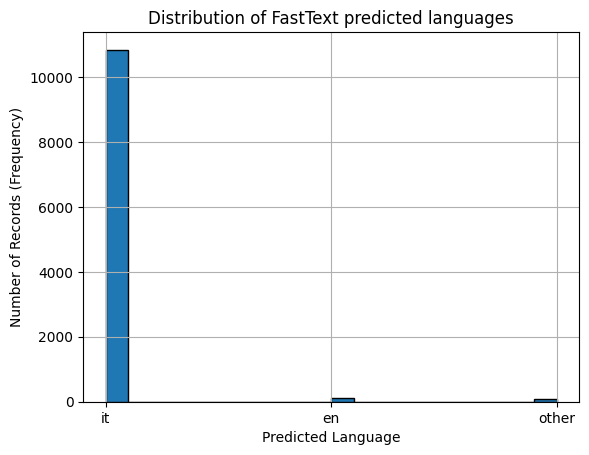

language
it       10840
en         114
other       78
Name: count, dtype: int64


In [26]:

df['language'].hist(
    bins=20, # Number of bins (intervals) for the histogram
    edgecolor='black'
)

plt.title('Distribution of FastText predicted languages')
plt.xlabel('Predicted Language')
plt.ylabel('Number of Records (Frequency)')
plt.show()


print(df['language'].value_counts())

## album, album_name, id_album preparation

We want to ensure a mapping between id_album and and album name. We have two features called album and album_name which contains the album name.

Album_name contains only 78 nan matching id_album's 78 whilst album has 1514.
Alubm_name has 2421 unique values, id_album has 3061 and album has only 890.

We consider album_name a suitable attribute to try and map the tracks album to id_album but we also use album to recover missing values.

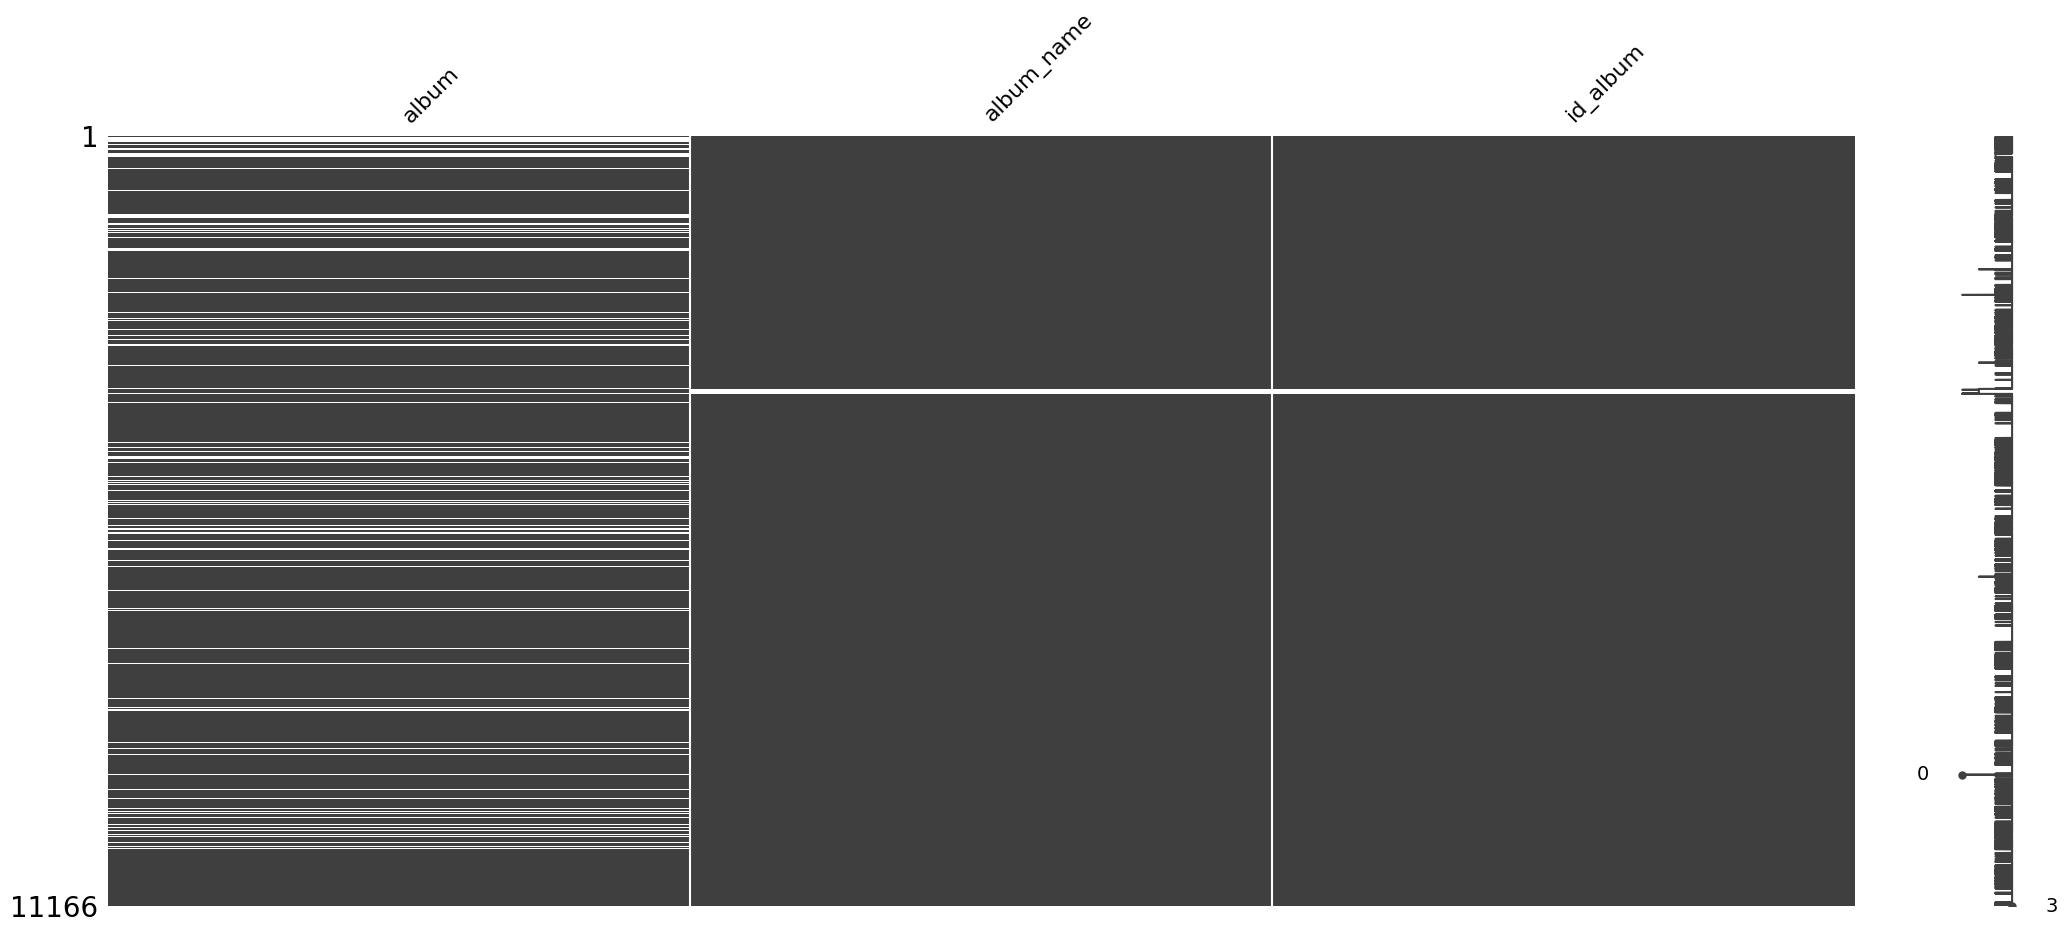

In [27]:
import missingno as msno
import matplotlib.pyplot as plt

# Plot the matrix
msno.matrix(df[['album', 'album_name', 'id_album']])
plt.show()


In [28]:
print("--- Creazione di 'correct_album' ---")

# Applica la normalizzazione alle due colonne originali
df['album_norm'] = normalize_series(df['album'])
df['album_name_norm'] = normalize_series(df['album_name'])

# Define conditions for the 'correct_album' selection
conditions = [
    # 1. Handle cases where both are missing (P1: If 'album_name_norm' is missing)
    (df['album_name_norm'].isna()), 
    
    # 2. Handle cases where the comparison itself involves a missing value, 
    #    but only one is missing (P2: If ONLY 'album_norm' is missing)
    #    (If 'album_name_norm' is missing, it's caught by P1)
    (df['album_norm'].isna()),
    
    # 3. Mismatch: Ensure neither is missing before comparison (P3: Mismatch)
    (df['album_norm'].notna() & df['album_name_norm'].notna() & \
     (df['album_norm'] != df['album_name_norm'])), 
    
    # 4. Match: (P4: Match)
    (df['album_norm'].notna() & df['album_name_norm'].notna() & \
     (df['album_norm'] == df['album_name_norm'])) 
]

# Define the corresponding choices
# The choices must reflect the order of the new conditions.
choices = [
    df['album_norm'],        # C1: P1 is true ('album_name_norm' is missing). Use 'album_norm'. (This will likely be NA/NaN).
    df['album_name_norm'],   # C2: P2 is true ('album_norm' is missing). Use 'album_name_norm'. (This will be NA/NaN).
    df['album_name_norm'],        # C3: P3 (Mismatch) is true. Use 'album_norm' (or 'album_name_norm' for the other value).
    df['album_norm']         # C4: P4 (Match) is true. Use either one.
]

# Create the initial, noisy 'correct_album' column
df['correct_album'] = np.select(conditions, choices, default=pd.NA)
print("Colonna 'correct_album' iniziale creata with robust NaN handling.")


print(f"\nNew correct album missing values: \n{df['correct_album'].isna().sum()} ")

print(f"\nNew correct album unique values: \n{df['correct_album'].nunique()}")

--- Creazione di 'correct_album' ---
Colonna 'correct_album' iniziale creata with robust NaN handling.

New correct album missing values: 
6 

New correct album unique values: 
2417


### Further analysis to ensure 1 correct_album_name per id

By merging album into album_name where it was missing we recover 72 values we now want to be able to have a consistent correct_album_name per id_abum

We notice that we may have different correct_album mapped to the same id_album. They are two cases: 1. Correct album is from a different artist an thus the id_album should be different 2. Correct_album is from same artist but maybe the album has a slight different name.

We perform a remapping of correct_album using as an identifier id_album and name_artist


In [29]:

def get_first_mode(series):
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    # If all are NaN, return NaN (or keep original if you prefer)
    return pd.NA 


df['correct_album'] = df.groupby(['id_album', 'name_artist'], dropna=False)['correct_album'].transform(get_first_mode)



artist_modes = df.groupby('name_artist')['correct_album'].transform(get_first_mode)

# 2. Identify the rows where id_album is missing (NaN)
missing_id_mask = df['id_album'].isna()

# 3. Update 'correct_album' ONLY for those specific rows
# We take the calculated modes and paste them only where the mask is True
df.loc[missing_id_mask, 'correct_album'] = artist_modes[missing_id_mask]

/tmp/ipykernel_9029/2620314848.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['correct_album'] = df.groupby(['id_album', 'name_artist'], dropna=False)['correct_album'].transform(get_first_mode)


In [30]:
# 1. Identify IDs that have more than 1 unique album name
id_name_counts = df.groupby('id_album')['correct_album'].nunique()
conflicting_ids = id_name_counts[id_name_counts > 1].index

print(f"Number of id_album with conflicting names: {len(conflicting_ids)}")

# 2. Print Examples of the conflicts
print("\n--- EXAMPLES OF CONFLICTS ---")

if len(conflicting_ids) > 0:
    # Look at the first 5 conflicting IDs
    for album_id in conflicting_ids[:5]:
        # Get all the unique names associated with this specific ID
        variations = df[df['id_album'] == album_id]['correct_album'].unique()
        
        print(f"\nID: {album_id}")
        print(f"Variations found: {list(variations)}")
else:
    print("No conflicts found! All IDs map to exactly one name.")

Number of id_album with conflicting names: 5

--- EXAMPLES OF CONFLICTS ---

ID: ALB156429
Variations found: ['ma vaffanculo', 'its snowing motherfucker']

ID: ALB275546
Variations found: ['la maggior parte', 'poco di buono']

ID: ALB473208
Variations found: ['malavita pt 2 headshot vol 3', 'il mio lato peggiore']

ID: ALB504235
Variations found: ['affetto illimitato', 'handmade cities']

ID: ALB877400
Variations found: ['allora ciao', 'red bull 64 bars the album']


/tmp/ipykernel_9029/3069398458.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  id_name_counts = df.groupby('id_album')['correct_album'].nunique()


In [31]:
# 1. Create "Reference Dictionary" (The Map)
valid_rows = df.dropna(subset=['id_album'])[['name_artist', 'correct_album', 'id_album']].drop_duplicates()
id_map = valid_rows.set_index(['name_artist', 'correct_album'])['id_album'].to_dict()

# 2. Check how many we can recover (Optional)
missing_mask = df['id_album'].isna()
recoverable_count = df.loc[missing_mask].set_index(['name_artist', 'correct_album']).index.map(id_map).notna().sum()
print(f"Found {recoverable_count} rows that can be recovered via mapping!")

# 3. Apply the Patch (THE FIX IS HERE)
# We perform the map, then immediately convert the resulting Index into a Series
# We strictly enforce 'index=df.index' so the new values line up with the correct rows
mapped_ids = df.set_index(['name_artist', 'correct_album']).index.map(id_map)
fill_values = pd.Series(mapped_ids, index=df.index) 

df['id_album'] = df['id_album'].fillna(fill_values)

# 4. Verify results
print(f"Remaining missing IDs: {df['id_album'].isna().sum()}")

Found 5 rows that can be recovered via mapping!
Remaining missing IDs: 73


In [32]:
def format_album_id(number, prefix='ALB', padding=6):
    """Formats a number into a ALBXXXXXX string."""
    return f"{prefix}{number:0{padding}d}"

print("--- Starting ID Conflict Resolution ---")

# Keep track of the original columns to ensure we don't duplicate them
original_cols = df.columns.tolist()

ref_df = df.dropna(subset=['id_album'])[['id_album', 'name_artist', 'correct_album']].drop_duplicates()
conflicting_mask = ref_df.duplicated(subset=['id_album'], keep='first')

# These are the specific Artist/Album pairs that need a NEW ID
rows_to_fix = ref_df[conflicting_mask].copy()

num_fix_needed = len(rows_to_fix)

if num_fix_needed == 0:
    print("✅ No conflicts found. No changes needed.")
else:
    print(f"Found {num_fix_needed} Artist/Album pairs sharing an ID with someone else.")

    # --- Generate New Unique IDs ---
    existing_ids = set(df['id_album'].dropna().unique())
    new_generated_ids = []
    MIN_ID = 0
    MAX_ID = 999999 

    print(f"Generating {num_fix_needed} random unique ALB IDs...")

    while len(new_generated_ids) < num_fix_needed:
        random_num = random.randint(MIN_ID, MAX_ID)
        new_id = format_album_id(random_num)
        if new_id not in existing_ids:
            new_generated_ids.append(new_id)
            existing_ids.add(new_id)

    rows_to_fix['new_id_album'] = new_generated_ids

    print("Applying fixes to main DataFrame (Index-Safe)...")

    # --- FIX 1: INDEX-SAFE MERGE ---
    # 1. Reset index to save it as a column
    df_temp = df.reset_index() 
    
    # 2. Perform the merge
    df_merged = df_temp.merge(
        rows_to_fix[['name_artist', 'correct_album', 'new_id_album']],
        on=['name_artist', 'correct_album'],
        how='left'
    )
    
    # 3. Restore the index
    # If your original index had a name (e.g., 'track_id'), use that. 
    # If it was unnamed, reset_index call it 'index'.
    index_col_name = df_temp.columns[0] # The first column is the old index
    df = df_merged.set_index(index_col_name)
    df.index.name = None # Clean up the name if desired

    # Update the 'id_album' column
    df['id_album'] = df['new_id_album'].fillna(df['id_album'])
    df = df.drop(columns=['new_id_album'])

    print(f"✅ Resolved {num_fix_needed} conflicts. New IDs assigned.")


print("\n--- Starting Missing ID Generation (Grouped by Artist) ---")

# 1. Identify rows where id_album is MISSING (NaN)
missing_mask = df['id_album'].isna()
artists_to_fix = df.loc[missing_mask, 'name_artist'].unique()
num_fix_needed = len(artists_to_fix)

if num_fix_needed == 0:
    print("✅ No missing IDs found. No changes needed.")
else:
    print(f"Found {num_fix_needed} Artists with missing Album IDs.")

    existing_ids = set(df['id_album'].dropna().unique())
    new_generated_ids = []

    print(f"Generating {num_fix_needed} random unique ALB IDs...")

    while len(new_generated_ids) < num_fix_needed:
        random_num = random.randint(MIN_ID, MAX_ID)
        new_id = format_album_id(random_num)
        if new_id not in existing_ids:
            new_generated_ids.append(new_id)
            existing_ids.add(new_id)

    # --- FIX 2: USING MAP INSTEAD OF MERGE ---
    # This is faster and does NOT touch the index at all.
    
    # Create a dictionary: Artist -> New ID
    artist_id_map = dict(zip(artists_to_fix, new_generated_ids))
    
    print("Applying fixes to main DataFrame (Direct Mapping)...")
    
    # We only update the rows where id_album is missing
    # Logic: Map the artist name to the new ID dictionary
    filled_ids = df.loc[missing_mask, 'name_artist'].map(artist_id_map)
    
    # Assign strictly to the missing locations
    df.loc[missing_mask, 'id_album'] = filled_ids
    
    print(f"✅ Generated and assigned {num_fix_needed} new IDs for missing values.")

--- Starting ID Conflict Resolution ---
Found 5 Artist/Album pairs sharing an ID with someone else.
Generating 5 random unique ALB IDs...
Applying fixes to main DataFrame (Index-Safe)...
✅ Resolved 5 conflicts. New IDs assigned.

--- Starting Missing ID Generation (Grouped by Artist) ---
Found 1 Artists with missing Album IDs.
Generating 1 random unique ALB IDs...
Applying fixes to main DataFrame (Direct Mapping)...
✅ Generated and assigned 1 new IDs for missing values.


In [33]:
print(df[['id_album', 'name_artist', 'correct_album']].info())

<class 'pandas.core.frame.DataFrame'>
Index: 11166 entries, TR934808 to TR552777
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id_album       11166 non-null  object
 1   name_artist    11166 non-null  string
 2   correct_album  11165 non-null  object
dtypes: object(2), string(1)
memory usage: 607.0+ KB
None


In [35]:
# 1. Identify the violating album names (where the same name maps to > 1 unique ID)
check_albums_per_id = df.groupby('correct_album')['id_album'].nunique()
violating_album_names = check_albums_per_id[check_albums_per_id > 1].index.tolist()

print(f"\n--- VIOLAZIONI: Album con più di 1 ID ({len(violating_album_names)} album) ---")

if violating_album_names:
    # 2. Filter the DataFrame for tracks belonging to the violating album names
    df_violations = df[df['correct_album'].isin(violating_album_names)]
    
    # 3. Print a sample of the incriminated lines
    #    We print 50 lines to show several distinct violations, 
    #    grouped by the violating name for better context.
    
    # Sort by the violating name and the ID to see the different IDs clearly
    df_violations_sorted = df_violations.sort_values(
        by=['correct_album', 'id_album']
    )

    print("\nEsempi di righe incriminate (Album name associated with multiple unique IDs):")
    # Display the first 50 rows of the sorted violations
    print(df_violations_sorted[['correct_album', 'id_album', 'album_type', 'name_artist']].head(60))
else:
    print("Nessuna violazione trovata! Il tuo mapping ID-first ha avuto successo.")


--- VIOLAZIONI: Album con più di 1 ID (348 album) ---

Esempi di righe incriminate (Album name associated with multiple unique IDs):
                      correct_album   id_album album_type    name_artist
TR605506                         10  ALB100356      album         madman
TR890254                         10  ALB721969      album         ghemon
TR269175                         17  ALB689025     single         madame
TR533807                         17  ALB756195      album     emis killa
TR818380                         17  ALB756195      album     emis killa
TR373885                         17  ALB756195      album     emis killa
TR648074                         17  ALB756195      album     emis killa
TR594038                         17  ALB756195      album     emis killa
TR670228                         17  ALB756195      album     emis killa
TR803223                         17  ALB756195      album     emis killa
TR452849                         17  ALB756195      album     e

In [37]:
# --- 1. Identify the Winning ID for Each Ambiguous Album Name ---

# Find the count of each ID associated with a final album name
id_counts = df.groupby(['correct_album', 'id_album']).size().reset_index(name='count')

# Find the ID with the MAX count (the 'Winner') for each album name
idx_max = id_counts.groupby('correct_album')['count'].idxmax()
winning_id_map = id_counts.loc[idx_max].set_index('correct_album')['id_album'].to_dict()

# --- 2. Create a column indicating the 'Winning ID' for each track ---
df['winning_id'] = df['correct_album'].map(winning_id_map)

# --- 3. Define the Reversion Condition and Choice ---

# Condition for Reversion:
# 1. The track's ID is NOT the winning ID for that album name (Minority track)
# AND
# 2. The album type is NOT 'single'
# reversion_condition = (df['id_album'] != df['winning_id']) & \
#                       (df['album_type'] != 'single')
reversion_condition = (df['id_album'] != df['winning_id'])


# Choice for Reversion:
# If the condition is True, revert the name to the less-cleaned 'album_norm'.
reversion_choice = df['album_norm']

# Default Choice (Keep the cleaned name):
# If the condition is False (it's the majority ID, or it's a single), keep the current 'correct_album_final'.
default_choice = df['correct_album']


# --- 4. Apply the Logic to Create the NEW Final Column ---
df['correct_album_final_resolved'] = np.select(
    [reversion_condition],
    [reversion_choice],
    default=default_choice
)

print("Conflict resolution applied. Check the new column 'correct_album_final_resolved'.")

# --- 5. Verification Check ---
print("\n--- NEW VIOLATION CHECK ---")

new_check = df.groupby('correct_album_final_resolved')['id_album'].nunique()
new_violations = new_check[new_check > 1].index.tolist()

print(f"Original violations: {len(violating_album_names)} album names")
print(f"New violations after reversion: {len(new_violations)} album names")



df_violations = df[df['correct_album_final_resolved'].isin(new_violations)]

# 3. Print a sample of the incriminated lines
#    We print 50 lines to show several distinct violations, 
#    grouped by the violating name for better context.

# Sort by the violating name and the ID to see the different IDs clearly
df_violations_sorted = df_violations.sort_values(
    by=['correct_album_final_resolved', 'id_album']
)

print("\nEsempi di righe incriminate (Album name associated with multiple unique IDs):")
# Display the first 50 rows of the sorted violations
print(df_violations_sorted[['correct_album_final_resolved', 'id_album', 'album_type', 'name_artist', 'album_norm']].head(60))

Conflict resolution applied. Check the new column 'correct_album_final_resolved'.

--- NEW VIOLATION CHECK ---
Original violations: 348 album names
New violations after reversion: 193 album names

Esempi di righe incriminate (Album name associated with multiple unique IDs):
         correct_album_final_resolved   id_album album_type    name_artist  \
TR861964                 107 elementi  ALB172256      album          neffa   
TR625294                 107 elementi  ALB266623      album          neffa   
TR960201                 107 elementi  ALB266623      album          neffa   
TR485812                 107 elementi  ALB266623      album          neffa   
TR860324                 107 elementi  ALB266623      album          neffa   
TR491025                 107 elementi  ALB266623      album          neffa   
TR279791                 107 elementi  ALB266623      album          neffa   
TR727867                 107 elementi  ALB266623      album          neffa   
TR701626               

In [38]:
# 1. CREATE A CONDITIONAL GROUPING KEY (The Fix for the ValueError)
# This key determines the level of grouping for the mode calculation:
# - If 'compilation', the key is just the album name (string).
# - Otherwise, the key is a tuple of (album_name, artist_name).

# A. Create the complex key (tuple) for ALL rows by default.
df['grouping_key'] = list(zip(df['correct_album_final_resolved'], df['name_artist']))

# B. Identify compilation rows.
is_compilation = (df['album_type'] == 'compilation')

# C. OVERWRITE the key for compilation rows with the simpler string key using .loc[]
df.loc[is_compilation, 'grouping_key'] = df.loc[is_compilation, 'correct_album_final_resolved']

# 2. DETERMINE THE MODAL (Most Frequent) id_album for each unique grouping key.
# This calculates the correct ID to use for every group.
modal_id_series = df.groupby('grouping_key')['id_album'].agg(
    # Use .mode()[0] to select the most frequent ID
    lambda x: x.mode()[0] if not x.mode().empty else pd.NA
)

# 3. MAP THE MODAL ID BACK TO THE ORIGINAL DATAFRAME
# Convert the modal Series to a dictionary for efficient mapping.
modal_id_map = modal_id_series.to_dict()

# Map the fixed ID onto a temporary column
df['id_album_fixed'] = df['grouping_key'].map(modal_id_map)

# 4. FINALIZE (Replace and Cleanup)
# Replace the original 'id_album' column with the new fixed column
df['id_album'] = df['id_album_fixed']

# Drop the temporary columns used for fixing
df = df.drop(columns=['grouping_key', 'id_album_fixed'])

print("✅ The 'id_album' column has been consistently fixed across the entire dataset.")
print("   - Standard albums were fixed by (Album, Artist).")
print("   - Compilation albums were fixed by Album name only.")

✅ The 'id_album' column has been consistently fixed across the entire dataset.
   - Standard albums were fixed by (Album, Artist).
   - Compilation albums were fixed by Album name only.


In [39]:
# 1. Group by the final cleaned album name and count the number of unique IDs
check_albums_per_id = df.groupby('correct_album_final_resolved')['id_album'].nunique()

# 2. Filter the resulting Series to keep only counts greater than 1
violating_album_counts = check_albums_per_id[check_albums_per_id > 1]

# 3. Print the result, sorted descending by the count (the most problematic albums first)
print("\n--- Album Names Associated with Multiple Unique IDs (Violations) ---")
print("Format: [Album Name] -> [Number of Unique IDs]")
print("Len of violating albums:", len(violating_album_counts))
print(violating_album_counts.sort_values(ascending=False).head(70))


--- Album Names Associated with Multiple Unique IDs (Violations) ---
Format: [Album Name] -> [Number of Unique IDs]
Len of violating albums: 29
correct_album_final_resolved
blocco 181 original soundtrack      7
esse magazine freestyle             3
17 dark edition                     2
5 dan                               2
21 motivi                           2
beatbox selection vol 1             2
bloody vinyl mixtape vol 1          2
difesa personale                    2
bv2                                 2
dove gli occhi non arrivano         2
fuori di qua                        2
game over mixtape vol 1             2
il mio diario giorno                2
k1 mixtape                          2
kill phil vol1                      2
mm vol 2                            2
noi siamo il club deluxe edition    2
prima di partire                    2
quello che vi consiglio vol 5       2
quello che vi consiglio vol 6       2
riscatto mixtape                    2
roccia music                

In [40]:
# Count how many rows exist for every combination of (Album Name, ID)
# We use the 'resolved' column as the grouping key
counts = df.groupby(['correct_album_final_resolved', 'id_album']).size().reset_index(name='count')

# Sort so the highest count is at the top for each album name
# In case of a tie, the logic picks the first one encountered (arbitrary tie-break)
winners = counts.sort_values(['correct_album_final_resolved', 'count'], ascending=[True, False])

# Keep only the top row for each album name (The Winner)
dominant_id_map = winners.drop_duplicates(subset=['correct_album_final_resolved']).set_index('correct_album_final_resolved')['id_album'].to_dict()

# --- 2. Detect Conflicts ---

# Map the "Dominant ID" back to every row in the dataframe
df['dominant_id'] = df['correct_album_final_resolved'].map(dominant_id_map)

# Identify "Minority" rows:
# Where the row's actual ID does NOT match the Dominant ID for that name
minority_mask = (df['id_album'] != df['dominant_id'])

# Optional: Exclude Singles from this logic if you want to be safe? 
# (If you want to revert singles too, remove the next line)
# minority_mask = minority_mask & (df['album_type'] != 'single') 

print(f"Found {minority_mask.sum()} rows where the Album Name conflicts with the Dominant ID.")

# --- 3. Execute the Reversion ---

# Update 'correct_album_final_resolved':
# IF it is a minority row -> Revert to 'album_norm'
# ELSE -> Keep it as is
df['correct_album_final_resolved'] = np.where(
    minority_mask,
    df['album_norm'],
    df['correct_album_final_resolved']
)

# --- 4. Cleanup ---
df = df.drop(columns=['dominant_id'])

print("Reversion complete. Conflicting minority groups have been split back to their raw names.")

Found 299 rows where the Album Name conflicts with the Dominant ID.
Reversion complete. Conflicting minority groups have been split back to their raw names.


In [41]:
df.drop(columns = ['album', 'album_name', 'album_norm', 'album_name_norm', 'correct_album', 'winning_id'], inplace = True)
df = df.rename(columns={'correct_album_final_resolved': 'album'})

## Stats page views

As considered in data understanding phase, almost 60% of records is missing (Nan) so we decided to drop the column.

In [42]:
df.drop(columns=['stats_pageviews'], inplace=True)

## Year, Month, Day and Album Release Date

there are multiple nan occurrences in month and day column so we decided to set such records at 01 to create a proper date based on the year.

In [43]:
date_components = {
    # CRITICAL CHANGE: Fill NaN in 'year' with 0. 
    # This prevents the ValueError by allowing astype('int64') to work.
    # The 'errors='coerce'' parameter will ensure year 0 converts to NaT.
    'year': df['year'].fillna(0).astype('Int64'),
    
    # These remain as before:
    'month': df['month'].fillna(1).astype('Int64'),
    'day': df['day'].fillna(1).astype('Int64')
}

df['date'] = pd.to_datetime(date_components, errors='coerce') 
df.drop(columns=['year', 'month', 'day'], inplace=True)

In [44]:
df_release = df.copy()

In [45]:
# --- 1. Creazione di un dataset "Lungo" con tutte le date e le info anagrafiche ---
# Manteniamo 'name_artist' e 'birth_date' nell'indice, poi impiliamo le date
df_all_dates = (
    df_release.set_index(['name_artist', 'birth_date'])[['date', 'album_release_date']]
    .stack()                        # Impila le colonne date in un'unica serie
    .reset_index(name='data_evento') # Trasforma in DataFrame, la colonna delle date si chiama 'data_evento'
    .drop(columns=['level_2'])      # Rimuove i nomi vecchi delle colonne ('date', 'album_release_date') che non servono
)

# --- 2. Creazione della Soglia di Controllo (+15 anni) ---
df_all_dates['soglia_adulto'] = df_all_dates['birth_date'] + pd.DateOffset(years=15)

# --- 3. Applicazione del Filtro Intelligente ---
# Vogliamo tenere la data SOLO se:
# A. La data è maggiore del 1960 (filtro rumore base)
#    AND
# B. (Manca la data di nascita) OR (C'è la nascita e la data evento è > 15 anni)

condizione_validita = (df_all_dates['data_evento'] >= '1988-01-01') & \
                      (
                          (df_all_dates['soglia_adulto'].isna()) | \
                          (df_all_dates['data_evento'] >= df_all_dates['soglia_adulto'])
                      )

# Applichiamo il filtro: questo rimuove tutte le tracce "infantili"
date_valide_plausibili = df_all_dates[condizione_validita]

# --- 4. Calcolo della Minima Storica (quella "dopo") ---
# Ora che abbiamo buttato le date impossibili, la .min() prenderà automaticamente
# la successiva più piccola valida.
min_storico_artista = date_valide_plausibili.groupby('name_artist')['data_evento'].min()

In [46]:
# --- 5. Integrazione nel calcolo finale (Come prima) ---
stima_storica = df_release['name_artist'].map(min_storico_artista)

soglia_master = df_release['active_start'].combine_first(
    df_release['birth_date'] + pd.DateOffset(years=15)
).combine_first(
    stima_storica 
)



In [47]:
# --- 5. Correction Pass 1: Fix TRACK Date using Album Date ---
# Condition: Track date is Future OR Missing OR Too Old
cond_fix_track = (df_release['date'] > pd.Timestamp.now()) | \
                 (df_release['date'].isna()) | \
                 (df_release['date'] < soglia_master)

print(f"Pass 1: Attempting to fix {cond_fix_track.sum()} bad track dates using Album Date...")
df_release.loc[cond_fix_track, 'date'] = df_release.loc[cond_fix_track, 'album_release_date']

# --- 6. Correction Pass 2: Fix ALBUM Date using Track Date ---
# Only applies if the Track Date is VALID (Safe Fix)

# Target: Album is Future OR Missing OR Too Old
album_broken = (df_release['album_release_date'] > pd.Timestamp.now()) | \
               (df_release['album_release_date'].isna()) | \
               (df_release['album_release_date'] < soglia_master)

# Source: Track is NOT Future AND NOT Missing AND Valid Age
track_valid = (df_release['date'] <= pd.Timestamp.now()) & \
              (df_release['date'].notna()) & \
              (df_release['date'] >= soglia_master)

apply_fix_album = album_broken & track_valid

print(f"Pass 2: Fixing {apply_fix_album.sum()} bad album dates using validated Track Date...")
df_release.loc[apply_fix_album, 'album_release_date'] = df_release.loc[apply_fix_album, 'date']

# --- 7. Final Cleanup (The Kill Switch) ---
# If the 'date' is STILL invalid after Pass 1 (meaning the Album date was also bad/missing),
# we must set it to NaT (Not a Time) to avoid polluting the analysis with impossible dates.

final_invalid = (df_release['date'] > pd.Timestamp.now()) | \
                (df_release['date'].isna()) | \
                (df_release['date'] < soglia_master)

df_release.loc[final_invalid, 'date'] = pd.NaT

# --- 8. Final Cleanup: Album Date (The Kill Switch) ---
# If 'album_release_date' is STILL invalid (meaning Track date couldn't save it), set to NaT.
final_invalid_album = (df_release['album_release_date'] > pd.Timestamp.now()) | \
                      (df_release['album_release_date'].isna()) | \
                      (df_release['album_release_date'] < soglia_master)

df_release.loc[final_invalid_album, 'album_release_date'] = pd.NaT
print(f"Final Cleanup (Albums): {final_invalid_album.sum()} unfixable dates set to NaT.")

print("Done. Dataset is now strictly compliant.")

print(f"Final Cleanup: {final_invalid.sum()} unfixable dates set to NaT.")
print("Done.")

Pass 1: Attempting to fix 2598 bad track dates using Album Date...
Pass 2: Fixing 295 bad album dates using validated Track Date...
Final Cleanup (Albums): 126 unfixable dates set to NaT.
Done. Dataset is now strictly compliant.
Final Cleanup: 126 unfixable dates set to NaT.
Done.


In [48]:
print(df_release[['album_release_date', 'date']].describe())

                  album_release_date                           date
count                          11040                          11040
mean   2017-01-27 02:58:33.913043456  2015-12-13 08:31:18.260869632
min              1988-05-10 00:00:00            1992-01-01 00:00:00
25%              2013-06-25 00:00:00            2011-12-12 00:00:00
50%              2018-06-29 00:00:00            2017-03-31 00:00:00
75%              2022-05-05 00:00:00            2021-06-04 00:00:00
max              2025-06-18 00:00:00            2025-06-20 00:00:00


After cleaning and filtering the dataset, the columns of album_release_date and date are redundant and both provide the same information on when did the track released.

We decided to use both column to correct the missing and non valid data and selected the best mode of the tracks in the same album (not the tracks with album_type=single) between the date mode and album_release_date mode.

Then we create the column release_date that has the same data for all the tracks in the same album (selected with the previous control) and for singles we decided to use the column date because of more accuracy in the "mode test".

In [50]:
group_keys = ['album'] 
def get_best_mode_info(group):
    """
    Calcola la moda e la frequenza per 'date' e 'album_release_date'
    e restituisce SIA LA FONTE ('date'/'album_release_date') 
    SIA IL VALORE (la data).
    """
    # Calcola mode e frequenze per 'date'
    date_counts = group['date'].value_counts()
    date_mode_freq = date_counts.iloc[0] if not date_counts.empty else 0
    date_mode_value = date_counts.index[0] if not date_counts.empty else pd.NaT

    # Calcola mode e frequenze per 'album_release_date'
    release_counts = group['album_release_date'].value_counts()
    release_mode_freq = release_counts.iloc[0] if not release_counts.empty else 0
    release_mode_value = release_counts.index[0] if not release_counts.empty else pd.NaT

    # Confronta le frequenze e definisci fonte e valore
    if date_mode_freq > release_mode_freq:
        source = 'date'
        value = date_mode_value
    elif release_mode_freq > date_mode_freq:
        source = 'album_release_date'
        value = release_mode_value
    elif date_mode_freq == 0: # Nessun dato valido
        source = 'none'
        value = pd.NaT
    else: 
        # Pareggio (date_mode_freq == release_mode_freq > 0)
        source = 'date' # Scegliamo 'date' come preferenza
        value = date_mode_value
    
    # Restituisci una Serie con entrambe le info
    return pd.Series({
        'best_mode_source': source, 
        'correct_release_date': value
    })

# 4. Calcola le info migliori per ogni gruppo (album)
print("Calcolo della moda migliore per ciascun album...")
# best_album_info ora sarà un DataFrame con colonne 'best_mode_source' e 'correct_release_date'
best_album_info = df_release.groupby(group_keys).apply(get_best_mode_info)

print("\n--- Conteggio finale delle fonti scelte ---")
final_counts = best_album_info['best_mode_source'].value_counts()
print(final_counts)

# Unisci (merge) questo DataFrame al DataFrame originale
# Pandas unirà 'best_mode_source' e 'correct_release_date'
df_release = df_release.merge(best_album_info, on=group_keys, how='left')

print("\nFatto! Colonne 'correct_release_date' e 'best_mode_source' aggiunte.")

# Controlla il risultato (mostrando tutte le colonne rilevanti)
print("\n--- Esempio di 10 righe casuali ---")
print(df_release.sample(n=10)[['album', 'date', 'album_release_date', 'correct_release_date']])

Calcolo della moda migliore per ciascun album...

--- Conteggio finale delle fonti scelte ---
best_mode_source
date                  1904
album_release_date     650
none                    24
Name: count, dtype: int64

Fatto! Colonne 'correct_release_date' e 'best_mode_source' aggiunte.

--- Esempio di 10 righe casuali ---
                              album       date album_release_date  \
4482                            dna 2018-09-01         2020-11-13   
5527   nei sogni nessuno e monogamo 2013-04-30         2022-03-03   
10555                 in cosa credi 2008-07-11         2008-07-11   
9712               cvlt hellraisers 2024-05-17         2024-05-17   
684       pizza con pina el musical 2018-10-16         2017-10-06   
3457          filosofia del fuckoff 2023-04-28         2023-04-28   
481                 destiny mixtape 2012-11-05         2022-06-24   
5436      vivere aiuta a non morire 2013-03-19         2013-01-01   
8626                    decrescendo 2025-05-23        

/tmp/ipykernel_9029/87836761.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_album_info = df_release.groupby(group_keys).apply(get_best_mode_info)


In [51]:
print(df_release.sample(n=10)[['album', 'date', 'album_release_date', 'correct_release_date']])

                           album       date album_release_date  \
3090                      famoso 2021-02-12         2021-02-12   
5681                    kamikaze 2017-06-05         2018-08-31   
2052                    bugiardo 2007-11-09         2007-11-09   
4034  le dimensioni del mio caos 2008-01-01         2008-01-01   
8796                        <NA> 2018-09-19         2022-05-17   
7835              la calda notte 2005-08-06         2005-08-06   
8330            scenario remixes 2015-10-30         2015-10-30   
8366       dio ce deluxe version 2015-05-26         2015-05-26   
2118             turbe giovanili        NaT                NaT   
430           re mida piano solo 2019-10-04         2019-10-01   

     correct_release_date  
3090           2021-02-12  
5681           2018-08-31  
2052           2007-11-09  
4034           2008-01-01  
8796                  NaT  
7835           2005-08-06  
8330           2015-10-30  
8366           2015-05-26  
2118           2002-0

In [52]:
condizione = (df_release['album_type'] == 'single')  ##MANCA CONDIZIONE (?)
df_release.loc[condizione, 'correct_release_date'] = df_release.loc[condizione, 'date']

In [ ]:
# Assuming 'best_album_info' is already calculated and ready for merge.

# 1. TEMPORARILY RESET THE ORIGINAL INDEX
# This converts the index named 'id' into a regular column named 'id'.
df = df.reset_index()

# 2. Reset the index of best_album_info (turning 'album' index into a column)
best_album_info_reset = best_album_info.reset_index()

# 3. Merge using the 'album' column as the key (column-to-column match)
# The DataFrame 'df' now contains both the join key ('album') and the index key ('id').
df = df.merge(
    best_album_info_reset, 
    on='album', 
    how='left',
    # Note: No 'on' or 'index' parameters are needed here, as it's a standard column merge
)

# 4. RESTORE THE ORIGINAL INDEX
# Set the 'id' column back as the index.
df = df.set_index('id')

print("✅ Merge complete. The original index 'id' has been successfully preserved.")

print("✅ Colonne 'correct_release_date' and 'best_mode_source' aggiunte al DataFrame originale 'df'.")

# Verification check (optional)
print("\n--- Esempio nel DataFrame 'df' ---")
print(df.sample(n=5)[['album', 'date', 'album_release_date', 'correct_release_date', 'best_mode_source']])

✅ Merge complete. The original index 'id' has been successfully preserved.
✅ Colonne 'correct_release_date' and 'best_mode_source' aggiunte al DataFrame originale 'df'.

--- Esempio nel DataFrame 'df' ---


KeyError: "['correct_release_date', 'best_mode_source'] not in index"

In [ ]:
df.info()

In [ ]:
df['active_start'] = df['active_start'].fillna(
    df.groupby('name_artist')['correct_release_date'].transform('min')
)

In [ ]:
condizione= (df['correct_release_date'].isna()) | (df['correct_release_date']<df['active_start'])
df.loc[condizione, 'correct_release_date'] = pd.NaT

In [ ]:
condizione= (df['correct_release_date'] > pd.Timestamp.now()) | (df['correct_release_date'].isna()) | (df['correct_release_date']<df['active_start'])
dati_filtrati = df.loc[condizione, ['correct_release_date', 'album','active_start', 'name_artist']]
dati_filtrati.head(50)

Active start was remodeled and filled the first date recorded of their tracks/albums.

In [ ]:
min_date = df['active_start'].min()
print(min_date)

# 2. Filter the DataFrame to find rows where 'active_start' equals the minimum date
rows_with_min_date = df[df['active_start'] == min_date]

# 3. Print the resulting rows
print("Rows where 'active_start' equals the minimum date:")
rows_with_min_date[['album', 'correct_release_date', 'date', 'album_release_date', 'album_type']].tail(50)

In [ ]:
col_drop = ['album_release_date', 'date', 'best_mode_source','new_release']
df.drop(columns=col_drop, inplace=True, errors='ignore')

In [ ]:
df.info()

## Popularity and Modified_popularity

When modified_popularity is 'true' (78 occurrences) the related popularity occurrence is not in the correct format.
We decided to drop the column modified_popularity and set the invalid popularity records to NaN.

In [ ]:
pop=df[df['modified_popularity']==True]
print(len(pop))

In [ ]:
condizione= (df['popularity']<0) | (df['popularity']>100) | (df['popularity'].isna())
dati_filtrati = df.loc[condizione, ['popularity', 'modified_popularity']]
dati_filtrati

In [ ]:
condizione= (df['popularity']<0) | (df['popularity']>100)
df.loc[condizione, 'popularity'] = np.nan
df.drop(columns=['modified_popularity'], inplace=True)

## Swear words control

We checked if the column Swear_IT and Swear_EN are coherent with the lyrics and their related Swear_IT_words and Swear_EN_words lists.

In [ ]:
from pandas.api.types import is_scalar # Importiamo il controllo specifico

## 1. Funzione per contare le parole nel testo (Versione 3)

def conta_parole_in_testo_corretto(riga):
    lista_parole = riga['swear_IT_words']
    testo_lyrics = riga['lyrics']

    # --- CORREZIONE ---
    # 1. Controlla il testo (che è sempre scalare)
    if pd.isna(testo_lyrics):
        return 0

    # 2. Controlla la lista/array
    # Prima controlla se è uno scalare (es. np.nan o None)
    if is_scalar(lista_parole):
        if pd.isna(lista_parole):
            return 0  # È np.nan o None, quindi 0
        else:
            return 0  # È uno scalare ma non nullo (es. un numero), non va bene
    
    # Se siamo qui, 'lista_parole' NON è uno scalare,
    # quindi è una lista o un array. Ora possiamo controllarne la lunghezza.
    if len(lista_parole) == 0:
        return 0
    # --- FINE CORREZIONE ---

    conteggio_totale = 0
    testo_lower = testo_lyrics.lower()

    for parola in lista_parole:
        parola_lower = str(parola).lower()
        pattern = r'\b' + re.escape(parola_lower) + r'\b'
        occorrenze = re.findall(pattern, testo_lower)
        conteggio_totale += len(occorrenze)

    return conteggio_totale

# --- ESECUZIONE DEL CONTROLLO ---

# 1. Calcola il nuovo conteggio applicando la funzione CORRETTA
print("1/3: Riconteggio delle parole nei testi (può richiedere tempo)...")
df['conteggio_calcolato'] = df.apply(conta_parole_in_testo_corretto, axis=1)

# 2. Prepara il conteggio originale
df['conteggio_originale'] = df['swear_IT'].fillna(0).astype(int)

# 3. Confronta i due conteggi
print("2/3: Confronto dei conteggi...")
incoerenze = df[df['conteggio_originale'] != df['conteggio_calcolato']]

# --- RISULTATO ---
print("3/3: Controllo completato.")
if incoerenze.empty:
    print("\n✅ Controllo superato! Tutti i conteggi 'swear_IT' corrispondono al ricalcolo dai testi.")
else:
    print(f"\n⚠️ Trovate {len(incoerenze)} righe incoerenti:")
    print(incoerenze[['artist', 'title', 'conteggio_originale', 'conteggio_calcolato', 'swear_IT_words']])

In [ ]:
## 1. Funzione per contare le parole nel testo (Versione 3)

def conta_parole_in_testo_corretto(riga):
    lista_parole = riga['swear_EN_words']
    testo_lyrics = riga['lyrics']

    # --- CORREZIONE ---
    # 1. Controlla il testo (che è sempre scalare)
    if pd.isna(testo_lyrics):
        return 0

    # 2. Controlla la lista/array
    # Prima controlla se è uno scalare (es. np.nan o None)
    if is_scalar(lista_parole):
        if pd.isna(lista_parole):
            return 0  # È np.nan o None, quindi 0
        else:
            return 0  # È uno scalare ma non nullo (es. un numero), non va bene
    
    # Se siamo qui, 'lista_parole' NON è uno scalare,
    # quindi è una lista o un array. Ora possiamo controllarne la lunghezza.
    if len(lista_parole) == 0:
        return 0
    # --- FINE CORREZIONE ---

    conteggio_totale = 0
    testo_lower = testo_lyrics.lower()

    for parola in lista_parole:
        parola_lower = str(parola).lower()
        pattern = r'\b' + re.escape(parola_lower) + r'\b'
        occorrenze = re.findall(pattern, testo_lower)
        conteggio_totale += len(occorrenze)

    return conteggio_totale

# --- ESECUZIONE DEL CONTROLLO ---

# 1. Calcola il nuovo conteggio applicando la funzione CORRETTA
print("1/3: Riconteggio delle parole nei testi (può richiedere tempo)...")
df['conteggio_calcolato'] = df.apply(conta_parole_in_testo_corretto, axis=1)

# 2. Prepara il conteggio originale
df['conteggio_originale'] = df['swear_EN'].fillna(0).astype(int)

# 3. Confronta i due conteggi
print("2/3: Confronto dei conteggi...")
incoerenze = df[df['conteggio_originale'] != df['conteggio_calcolato']]

# --- RISULTATO ---
print("3/3: Controllo completato.")
if incoerenze.empty:
    print("\n✅ Controllo superato! Tutti i conteggi 'swear_EN' corrispondono al ricalcolo dai testi.")
else:
    print(f"\n⚠️ Trovate {len(incoerenze)} righe incoerenti:")
    print(incoerenze[['artist', 'title', 'conteggio_originale', 'conteggio_calcolato', 'swear_EN_words']])

In [ ]:
lista_parole_it = list(df['swear_IT_words'].explode().dropna().unique())

# 2. Lista Inglese (EN)
# Stessa identica logica
lista_parole_en = list(df['swear_EN_words'].explode().dropna().unique())

# 3. Stampa i risultati
print(f"--- PAROLE UNICHE ITALIANE ({len(lista_parole_it)}) ---")
print(lista_parole_it)


In [ ]:

print(f"\n--- PAROLE UNICHE INGLESI ({len(lista_parole_en)}) ---")
print(lista_parole_en)

In [ ]:
condizione= (df['explicit']==False) & ((df['swear_IT']>0) | (df['swear_EN']>0))
dati_filtrati = df.loc[condizione, ['explicit', 'swear_IT', 'swear_EN']]
dati_filtrati
df.loc[condizione,['explicit']] = True

In [ ]:
condizione= (df['explicit']==True) & ((df['swear_IT']==0) & (df['swear_EN']==0))
dati_filtrati = df.loc[condizione, ['explicit', 'swear_IT', 'swear_EN']]
dati_filtrati
df.loc[condizione,['explicit']] = False

In [ ]:
df_swear=df.copy()
## 1. Preparazione: Creare i Pattern RegEx
#    Questa è la parte più importante per la velocità.
#    Trasformiamo ['a', 'b', 'c'] in r'\b(a|b|c)\b'

def crea_pattern(lista_parole):
    # 1. Assicura che siano tutte stringhe e minuscole
    parole_pulite = [str(p).lower() for p in lista_parole if pd.notna(p)]
    
    # 2. Fai l'escape di ogni parola (per gestire caratteri come 'f**k')
    parole_escaped = [re.escape(p) for p in parole_pulite]
    
    # 3. Uniscile con un OR (|)
    pattern_string = "|".join(parole_escaped)
    
    # 4. Racchiudi in \b (word boundary) per trovare solo parole intere
    #    e compila il pattern RegEx.
    return re.compile(r'\b(' + pattern_string + r')\b', re.IGNORECASE)

print("Creazione pattern RegEx in corso...")
pattern_it = crea_pattern(lista_parole_it)
pattern_en = crea_pattern(lista_parole_en)
print("Pattern creati.")


## 2. Definire la Funzione di Ricalcolo
#    Questa funzione verrà applicata a OGNI RIGA del DataFrame

def ricalcola_parole(riga):
    testo = riga['lyrics']
    
    # Se il testo è mancante, restituisci valori vuoti
    if pd.isna(testo):
        return 0, [], 0, [] # count_it, words_it, count_en, words_en

    # --- Processo Italiano ---
    # re.findall() trova TUTTE le occorrenze (anche duplicate)
    matches_it = pattern_it.findall(testo.lower())
    
    # Il conteggio è il numero totale di occorrenze
    conteggio_it = len(matches_it)
    # La lista di parole è l'insieme unico (set) delle parole trovate
    parole_uniche_it = list(set(matches_it))

    # --- Processo Inglese ---
    matches_en = pattern_en.findall(testo.lower())
    conteggio_en = len(matches_en)
    parole_uniche_en = list(set(matches_en))

    return conteggio_it, parole_uniche_it, conteggio_en, parole_uniche_en


## 3. Esecuzione e Aggiornamento
#    Applichiamo la funzione all'intero DataFrame

print("Inizio ricalcolo su tutto il DataFrame (può richiedere tempo)...")

# 'axis=1' applica la funzione a ogni riga
# 'result_type='expand'' divide il risultato della funzione (i 4 valori)
# in 4 nuove colonne
nuovi_valori = df_swear.apply(ricalcola_parole, axis=1, result_type='expand')

nuovi_valori.columns = ['swear_IT_new', 'swear_IT_words_new', 'swear_EN_new', 'swear_EN_words_new']

# Confrontiamo le vecchie colonne con le nuove
# Usiamo .fillna(0) per i conteggi e .ne() (Not Equal) per le liste

# 1. Confronto Conteggi
cond_it_count = df_swear['swear_IT'].fillna(0).ne(nuovi_valori['swear_IT_new'])
cond_en_count = df_swear['swear_EN'].fillna(0).ne(nuovi_valori['swear_EN_new'])

# 2. Confronto Liste
# .ne() gestisce correttamente il confronto tra liste e valori NaN/None
cond_it_words = df_swear['swear_IT_words'].ne(nuovi_valori['swear_IT_words_new'])
cond_en_words = df_swear['swear_EN_words'].ne(nuovi_valori['swear_EN_words_new'])

# 3. Condizione Totale: la riga è cambiata se ALMENO UNO dei 4 campi è diverso
condizione_cambiati = (cond_it_count | cond_en_count | cond_it_words | cond_en_words)

# 4. Stampa e Copia (come richiesto)
num_cambiati = condizione_cambiati.sum()
print(f"📊 Numero di record che verranno aggiornati: {num_cambiati}")

# Creiamo la copia delle righe *originali* che stanno per cambiare
df_swear_copy = df_swear[condizione_cambiati].copy()
print(f"📋 Creato 'df_swear_copy' con {len(df_swear_copy)} record (lo stato *prima* della modifica).")

# Assegna i nuovi valori alle colonne corrette del DataFrame originale
# (sovrascrivendo i vecchi dati)
df[['swear_IT', 'swear_IT_words', 'swear_EN', 'swear_EN_words']] = nuovi_valori

print("Ricalcolo completato! Le colonne sono state aggiornate.")


We discovered that the dataset was probably created by starting with a fixed swear words list but this list doesn't include plural and leads to not accurate records both in the swear_word collection, count and the explicit column.
We decided to just fix the explicit column according to our swear words counts and not manually insert the plural or the other word forms in the database.

In [ ]:
df.drop(columns=['conteggio_calcolato', 'conteggio_originale'], inplace=True)

In [ ]:
df.info()

## Music parameters control
Due to colineary with other features (rms, rolloff) we decided to drop loudness and zcr columns.

In [ ]:
df.drop(columns=['loudness','zcr'], inplace=True, errors='ignore')

In [ ]:
df_measures = df.copy()
# 1. Calcola Q1 e Q3 per la colonna 'bpm'
Q1 = df_measures['bpm'].quantile(0.25)
Q3 = df_measures['bpm'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'bpm' è DENTRO i limiti

condizione = ((df_measures['bpm'] < limite_inferiore) | (df_measures['bpm'] > limite_superiore))

#condizione = ((df_measures['bpm'] < 0.04) | (df_measures['bpm'] > 0.24))
# 5. Controlla il risultato
df_measures.loc[condizione, 'bpm'] = np.nan
nan_count = df_measures['bpm'].isnull().sum()
print(f"Numero di valori NaN in 'bpm': {nan_count}")

In [ ]:

# 1. Calcola Q1 e Q3 per la colonna 'centroid'
Q1 = df_measures['centroid'].quantile(0.25)
Q3 = df_measures['centroid'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'centroid' è DENTRO i limiti
#condizione = ((df_measures['centroid'] < limite_inferiore) | (df_measures['centroid'] > limite_superiore))

condizione = ((df_measures['centroid'] < 0.04) | (df_measures['centroid'] > 0.24))
# 5. Controlla il risultato
df_measures.loc[condizione, 'centroid'] = np.nan
nan_count = df_measures['centroid'].isnull().sum()
print(f"Numero di valori NaN in 'centroid': {nan_count}")

In [ ]:

# 1. Calcola Q1 e Q3 per la colonna 'rolloff'
Q1 = df_measures['rolloff'].quantile(0.25)
Q3 = df_measures['rolloff'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'rolloff' è DENTRO i limiti
#condizione = ((df_measures['rolloff'] < limite_inferiore) | (df_measures['rolloff'] > limite_superiore))

condizione = ((df_measures['rolloff'] < limite_inferiore) | (df_measures['rolloff'] > 6000))
# 5. Controlla il risultato
df_measures.loc[condizione, 'rolloff'] = np.nan
nan_count = df_measures['rolloff'].isnull().sum()
print(f"Numero di valori NaN in 'rolloff': {nan_count}")

In [ ]:

# 1. Calcola Q1 e Q3 per la colonna 'flux'
Q1 = df_measures['flux'].quantile(0.25)
Q3 = df_measures['flux'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'flux' è DENTRO i limiti
#condizione = ((df_measures['flux'] < limite_inferiore) | (df_measures['flux'] > limite_superiore))


condizione = ((df_measures['flux'] < 0.75) | (df_measures['flux'] > 1.75))
# 5. Controlla il risultato
df_measures.loc[condizione, 'flux'] = np.nan
nan_count = df_measures['flux'].isnull().sum()
print(f"Numero di valori NaN in 'flux': {nan_count}")

In [ ]:

# 1. Calcola Q1 e Q3 per la colonna 'rms'
Q1 = df_measures['rms'].quantile(0.25)
Q3 = df_measures['rms'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'rms' è DENTRO i limiti
#condizione = ((df_measures['rms'] < limite_inferiore) | (df_measures['rms'] > limite_superiore))

condizione = ((df_measures['rms'] < 0.) | (df_measures['rms'] > 0.43))
# 5. Controlla il risultato
df_measures.loc[condizione, 'rms'] = np.nan
nan_count = df_measures['rms'].isnull().sum()
print(f"Numero di valori NaN in 'rms': {nan_count}")

In [ ]:

# 1. Calcola Q1 e Q3 per la colonna 'rms'
Q1 = df_measures['duration_ms'].quantile(0.25)
Q3 = df_measures['duration_ms'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'duration_ms' è DENTRO i limiti
#condizione = ((df_measures['duration_ms'] < limite_inferiore) | (df_measures['duration_ms'] > limite_superiore))

condizione = ((df_measures['duration_ms'] <= 0) | (df_measures['duration_ms'] > 2e6))
# 5. Controlla il risultato
df_measures.loc[condizione, 'duration_ms'] = np.nan
nan_count = df_measures['duration_ms'].isnull().sum()
print(f"Numero di valori NaN in 'duration_ms': {nan_count}")

In [ ]:

# 1. Calcola Q1 e Q3 per la colonna 'flatness'
Q1 = df_measures['flatness'].quantile(0.25)
Q3 = df_measures['flatness'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'flatness' è DENTRO i limiti

#condizione = ((df_measures['flatness'] < limite_inferiore) | (df_measures['flatness'] > limite_superiore))

condizione = ((df_measures['flatness'] < 0.2) | (df_measures['flatness'] > limite_superiore))
# 5. Controlla il risultato
df_measures.loc[condizione, 'flatness'] = np.nan
nan_count = df_measures['flatness'].isnull().sum()
print(f"Numero di valori NaN in 'flatness': {nan_count}")

In [ ]:

# 1. Calcola Q1 e Q3 per la colonna 'spectral_complexity'
Q1 = df_measures['spectral_complexity'].quantile(0.25)
Q3 = df_measures['spectral_complexity'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'spectral_complexity' è DENTRO i limiti
#condizione = ((df_measures['spectral_complexity'] < limite_inferiore) | (df_measures['spectral_complexity'] > limite_superiore))

condizione = ((df_measures['spectral_complexity'] <= 0) | (df_measures['spectral_complexity'] > 55))
# 5. Controlla il risultato
df_measures.loc[condizione, 'spectral_complexity'] = np.nan
nan_count = df_measures['spectral_complexity'].isnull().sum()
print(f"Numero di valori NaN in 'spectral_complexity': {nan_count}")

In [ ]:

# 1. Calcola Q1 e Q3 per la colonna 'pitch'
Q1 = df_measures['pitch'].quantile(0.25)
Q3 = df_measures['pitch'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'pitch' è DENTRO i limiti
#condizione = ((df_measures['pitch'] < limite_inferiore) | (df_measures['pitch'] > limite_superiore))

condizione = ((df_measures['pitch'] < 1000) | (df_measures['pitch'] > 4000))
# 5. Controlla il risultato
df_measures.loc[condizione, 'pitch'] = np.nan
nan_count = df_measures['pitch'].isnull().sum()
print(f"Numero di valori NaN in 'pitch': {nan_count}")

In [ ]:

# 1. Calcola Q1 e Q3 per la colonna 'pitch'
Q1 = df_measures['n_tokens'].quantile(0.25)
Q3 = df_measures['n_tokens'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'n_tokens' è DENTRO i limiti
#condizione = ((df_measures['n_tokens'] < limite_inferiore) | (df_measures['n_tokens'] > limite_superiore))

condizione = ((df_measures['n_tokens'] < 1) | (df_measures['n_tokens'] > 2000))
# 5. Controlla il risultato
df_measures.loc[condizione, 'n_tokens'] = np.nan
nan_count = df_measures['n_tokens'].isnull().sum()
print(f"Numero di valori NaN in 'n_tokens': {nan_count}")

In [ ]:

# 1. Calcola Q1 e Q3 per la colonna 'pitch'
Q1 = df_measures['tokens_per_sent'].quantile(0.25)
Q3 = df_measures['tokens_per_sent'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'tokens_per_sent' è DENTRO i limiti
#condizione = ((df_measures['tokens_per_sent'] < limite_inferiore) | (df_measures['tokens_per_sent'] > limite_superiore))

condizione = ((df_measures['tokens_per_sent'] < 1) | (df_measures['tokens_per_sent'] > 100))
# 5. Controlla il risultato
df_measures.loc[condizione, 'tokens_per_sent'] = np.nan
nan_count = df_measures['tokens_per_sent'].isnull().sum()
print(f"Numero di valori NaN in 'tokens_per_sent': {nan_count}")

In [ ]:
# 1. Calcola Q1 e Q3 per la colonna 'pitch'
Q1 = df_measures['lexical_density'].quantile(0.25)
Q3 = df_measures['lexical_density'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'lexical_density' è DENTRO i limiti
#condizione = ((df_measures['lexical_density'] < limite_inferiore) | (df_measures['lexical_density'] > limite_superiore))

condizione = ((df_measures['lexical_density'] < 0.05) | (df_measures['lexical_density'] > 0.95))
# 5. Controlla il risultato
df_measures.loc[condizione, 'lexical_density'] = np.nan
nan_count = df_measures['lexical_density'].isnull().sum()
print(f"Numero di valori NaN in 'lexical_density': {nan_count}")

In [ ]:
# 1. Calcola Q1 e Q3 per la colonna 'pitch'
Q1 = df_measures['avg_token_per_clause'].quantile(0.25)
Q3 = df_measures['avg_token_per_clause'].quantile(0.75)

# 2. Calcola l'IQR
IQR = Q3 - Q1

# 3. Definisci i limiti
limite_superiore = Q3 + (1.5 * IQR)
limite_inferiore = Q1 - (1.5 * IQR)

print(f"Limite inferiore: {limite_inferiore}")
print(f"Limite superiore: {limite_superiore}")

# 4. Filtra il DataFrame
# Manteniamo solo le righe dove 'avg_token_per_clause' è DENTRO i limiti
#condizione = ((df_measures['avg_token_per_clause'] < limite_inferiore) | (df_measures['avg_token_per_clause'] > limite_superiore))

condizione = ((df_measures['avg_token_per_clause'] < 0) | (df_measures['avg_token_per_clause'] > 175))
# 5. Controlla il risultato
df_measures.loc[condizione, 'avg_token_per_clause'] = np.nan
nan_count = df_measures['avg_token_per_clause'].isnull().sum()
print(f"Numero di valori NaN in 'avg_token_per_clause': {nan_count}")

In [ ]:
colonne_da_sostituire = ['bpm', 'centroid', 'duration_ms', 'rolloff', 'flux', 'rms', 'flatness', 'spectral_complexity', 'pitch', 'n_tokens', 'tokens_per_sent', 'lexical_density', 'avg_token_per_clause']

df[colonne_da_sostituire] = df_measures[colonne_da_sostituire]

nan_count = df_measures[colonne_da_sostituire].isnull().sum()
print(nan_count)

In [ ]:
# Create a copy of the DataFrame to work on
df_track_number = df.copy()

# 1. Establish the correct order
# Crucial Step: Sort by 'id_album' first, and then by the existing 'track_number'
# This ensures that when we re-index (using cumcount), we maintain the intended order
df_track_number.sort_values(by=['id_album', 'track_number'], inplace=True)

# 2. Re-index Tracks within Each Album Group
# groupby('id_album') isolates each album.
# cumcount() counts the rows sequentially (0, 1, 2, ...) within each isolated group.
# We add + 1 to make it 1-based (1, 2, 3, ...)
df_track_number['Clean_Track_Number'] = df_track_number.groupby('id_album').cumcount() + 1

# 3. Optional: Compare Old and New Track Numbers (for verification)
# We can drop the old 'track_number' if we only need the clean one,
# but keeping it temporarily shows the impact of the cleaning.
# print(df_track_number[['id_album', 'track_number', 'Clean_Track_Number']].head(20))

# 4. Replace the old track_number column with the new, clean column
df_track_number.drop(columns=['track_number'], inplace=True)
df_track_number.rename(columns={'Clean_Track_Number': 'track_number'}, inplace=True)


# Verification Step: Re-run the count and max check to show the data is now consistent
print("--- Verification Check After Cleaning ---")

# Max Track Number should now equal Total Track Count for ALL albums
max_tracks_clean = df_track_number.groupby('id_album')['track_number'].max().rename('Max_Track_Number_Clean')
total_tracks_clean = df_track_number.groupby('id_album')['track_number'].count().rename('Total_Track_Count_Clean')

album_summary_clean = pd.concat([max_tracks_clean, total_tracks_clean], axis=1)

# Check for mismatches again (should be 0 now)
mismatch_count_clean = (album_summary_clean['Max_Track_Number_Clean'] != album_summary_clean['Total_Track_Count_Clean']).sum()

print(f"Total number of albums with a track number/count mismatch (AFTER CLEANING): {mismatch_count_clean}")
print("\nCleaned Album Summary Head:")
print(album_summary_clean.head())

df['track_number'] = df_track_number['track_number']

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
prova = df[df['name_artist'] == 'NA']
prova

In [ ]:
df.to_csv('dataset/df_cleaned.csv', index=True)

In [ ]:
df.info()

In [ ]:
# 1. Define the list of meaningful numeric columns you want to plot
features = [
    'n_sentences',
    'n_tokens',
    'tokens_per_sent',
    'char_per_tok',
    'lexical_density',
    'avg_token_per_clause',
    'bpm',
    'centroid',
    'rolloff',
    'flux',
    'rms',
    'flatness',
    'spectral_complexity',
    'pitch',
    'duration_ms'
]

# 2. Select the subset of data
df_subset = df[features]

# 3. Calculate the correlation matrix on the subset
corr_matrix_subset = df_subset.corr()

# 4. Plot the results
plt.figure(figsize=(16, 16)) # Use a smaller figure size for fewer columns
sns.heatmap(corr_matrix_subset, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix:", fontsize=14)
plt.show()